In [1]:
# Make sure results are repeatable
from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

In [2]:
import pandas as pd

df = pd.read_csv('pacific-heights.csv')
df.head()

,address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zipcode
0,2243 Franklin St,2.0,2,1463,2/5/2016,1950000,37.795139,-122.425309,Pacific Heights,7,Condominium,1900,94109
1,2002 Pacific Ave APT 4,3.5,3,3291,1/22/2016,4200000,37.794429,-122.428513,Pacific Heights,7,Condominium,1961,94109
2,1945 Washington St APT 411,1.0,1,653,12/16/2015,665000,37.792472,-122.425281,Pacific Heights,3,Condominium,1987,94109
3,1896 Pacific Ave APT 802,2.5,2,2272,12/17/2014,2735000,37.794706,-122.426347,Pacific Heights,6,Condominium,1924,94109
4,1840 Washington St APT 603,1.0,1,837,12/2/2015,1050000,37.793212,-122.423744,Pacific Heights,3,Condominium,2012,94109


In [3]:
df.shape

(439, 13)

In [4]:
corr_matrix = df.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice    1.000000
finishedsqft     0.840864
bathrooms        0.768179
totalrooms       0.670726
bedrooms         0.606579
zipcode          0.296032
latitude         0.126480
yearbuilt       -0.214365
longitude       -0.309462
Name: lastsoldprice, dtype: float64

In [5]:
df = pd.get_dummies(df, columns=['usecode'])
df.head()

,address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,yearbuilt,zipcode,usecode_Condominium,usecode_Cooperative,usecode_Duplex,usecode_MultiFamily2To4,usecode_SingleFamily,usecode_Townhouse
0,2243 Franklin St,2.0,2,1463,2/5/2016,1950000,37.795139,-122.425309,Pacific Heights,7,1900,94109,1,0,0,0,0,0
1,2002 Pacific Ave APT 4,3.5,3,3291,1/22/2016,4200000,37.794429,-122.428513,Pacific Heights,7,1961,94109,1,0,0,0,0,0
2,1945 Washington St APT 411,1.0,1,653,12/16/2015,665000,37.792472,-122.425281,Pacific Heights,3,1987,94109,1,0,0,0,0,0
3,1896 Pacific Ave APT 802,2.5,2,2272,12/17/2014,2735000,37.794706,-122.426347,Pacific Heights,6,1924,94109,1,0,0,0,0,0
4,1840 Washington St APT 603,1.0,1,837,12/2/2015,1050000,37.793212,-122.423744,Pacific Heights,3,2012,94109,1,0,0,0,0,0


In [6]:
corr_matrix = df.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice              1.000000
finishedsqft               0.840864
bathrooms                  0.768179
totalrooms                 0.670726
usecode_SingleFamily       0.638482
bedrooms                   0.606579
zipcode                    0.296032
latitude                   0.126480
usecode_Duplex             0.006292
usecode_MultiFamily2To4   -0.019009
usecode_Townhouse         -0.025467
usecode_Cooperative       -0.025556
yearbuilt                 -0.214365
longitude                 -0.309462
usecode_Condominium       -0.598575
Name: lastsoldprice, dtype: float64

In [7]:
# Filter the dataset down to the most significant columns
df = df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode_Condominium', 'lastsoldprice']]
df.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,usecode_Condominium,lastsoldprice
0,2.0,2,1463,7,1,1950000
1,3.5,3,3291,7,1,4200000
2,1.0,1,653,3,1,665000
3,2.5,2,2272,6,1,2735000
4,1.0,1,837,3,1,1050000


In [8]:
df = df.rename(index=str, columns={'usecode_Condominium': 'iscondo'})

In [9]:
corr_matrix = df.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice    1.000000
finishedsqft     0.840864
bathrooms        0.768179
totalrooms       0.670726
bedrooms         0.606579
iscondo         -0.598575
Name: lastsoldprice, dtype: float64

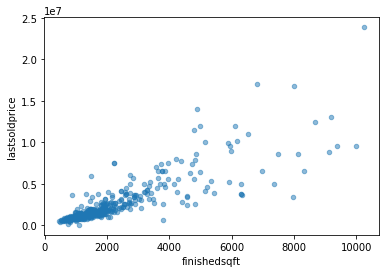

In [10]:
%matplotlib inline

df.plot(kind="scatter", x="finishedsqft", y="lastsoldprice", alpha=0.5)

In [11]:
# Split the dataset into a training set and a test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('lastsoldprice', axis=1), df['lastsoldprice'], test_size=0.2, random_state=0)

In [12]:
# Define the model
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=5, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1)) 
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [13]:
# Train the model
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

Train on 351 samples, validate on 88 samples
Epoch 1/100
351/351 [==============================] - 0s 996us/step - loss: 2499539.4341 - mean_absolute_error: 2499539.4341 - val_loss: 2591293.4830 - val_mean_absolute_error: 2591293.4830
Epoch 2/100
351/351 [==============================] - 0s 100us/step - loss: 2497880.0299 - mean_absolute_error: 2497880.0299 - val_loss: 2589625.1136 - val_mean_absolute_error: 2589625.1136
Epoch 3/100
351/351 [==============================] - 0s 103us/step - loss: 2496070.2678 - mean_absolute_error: 2496070.2678 - val_loss: 2587475.8523 - val_mean_absolute_error: 2587475.8523
Epoch 4/100
351/351 [==============================] - 0s 87us/step - loss: 2493549.5826 - mean_absolute_error: 2493549.5826 - val_loss: 2584383.4659 - val_mean_absolute_error: 2584383.4659
Epoch 5/100
351/351 [==============================] - 0s 108us/step - loss: 2489810.9459 - mean_absolute_error: 2489810.9459 - val_loss: 2579871.1193 - val_mean_absolute_error: 2579871.1193
E

Epoch 44/100
351/351 [==============================] - 0s 89us/step - loss: 743559.5504 - mean_absolute_error: 743559.5504 - val_loss: 803531.2429 - val_mean_absolute_error: 803531.2429
Epoch 45/100
351/351 [==============================] - 0s 89us/step - loss: 743675.9046 - mean_absolute_error: 743675.9046 - val_loss: 802997.0085 - val_mean_absolute_error: 802997.0085
Epoch 46/100
351/351 [==============================] - 0s 100us/step - loss: 743402.8511 - mean_absolute_error: 743402.8511 - val_loss: 803059.0724 - val_mean_absolute_error: 803059.0724
Epoch 47/100
351/351 [==============================] - 0s 95us/step - loss: 743294.6580 - mean_absolute_error: 743294.6580 - val_loss: 802846.1435 - val_mean_absolute_error: 802846.1435
Epoch 48/100
351/351 [==============================] - 0s 95us/step - loss: 743418.7738 - mean_absolute_error: 743418.7738 - val_loss: 803156.0980 - val_mean_absolute_error: 803156.0980
Epoch 49/100
351/351 [==============================] - 0s 100us

Epoch 88/100
351/351 [==============================] - 0s 145us/step - loss: 743198.7017 - mean_absolute_error: 743198.7017 - val_loss: 802788.9972 - val_mean_absolute_error: 802788.9972
Epoch 89/100
351/351 [==============================] - 0s 156us/step - loss: 743160.1322 - mean_absolute_error: 743160.1322 - val_loss: 803061.5824 - val_mean_absolute_error: 803061.5824
Epoch 90/100
351/351 [==============================] - 0s 143us/step - loss: 743452.8730 - mean_absolute_error: 743452.8730 - val_loss: 803476.0795 - val_mean_absolute_error: 803476.0795
Epoch 91/100
351/351 [==============================] - 0s 140us/step - loss: 743227.4658 - mean_absolute_error: 743227.4658 - val_loss: 802505.3935 - val_mean_absolute_error: 802505.3935
Epoch 92/100
351/351 [==============================] - 0s 111us/step - loss: 743448.3995 - mean_absolute_error: 743448.3995 - val_loss: 802944.2372 - val_mean_absolute_error: 802944.2372
Epoch 93/100
351/351 [==============================] - 0s 1

[]

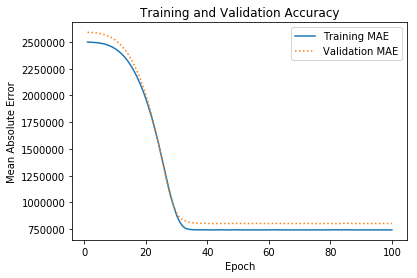

In [14]:
# Plot training accuracy and validation accuracy over time
%matplotlib inline
import matplotlib.pyplot as plt

err = hist.history['mean_absolute_error']
val_err = hist.history['val_mean_absolute_error']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

In [15]:
# Compute the R2 score
from sklearn import metrics

print('R2: ' + str(metrics.r2_score(y_test, model.predict(x_test))))

R2: 0.6274747516733795


In [16]:
# Score the model
scores = model.evaluate(x_test, y_test, verbose=0)

for i in range(0, len(scores)):
    print(model.metrics_names[i] + ': ' + str(scores[i]))

loss: 802626.2954545454
mean_absolute_error: 802626.2954545454


In [17]:
# Use the model to make a prediction
import numpy as np

bathrooms = 1
bedrooms = 1
finished_sqft = 1040
total_rooms = 4
is_condo = 1

model.predict(np.array([[bathrooms, bedrooms, finished_sqft, total_rooms, is_condo]]))

array([[1082372.4]], dtype=float32)